<a href="https://colab.research.google.com/github/drwatson93/Pneumonia-Detection-using-CNN/blob/main/Pneumonia_Detection_using_TensorFlow_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install streamlit
!pip install pyngrok

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip chest-xray-pneumonia
#! unzip ex_test

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**

<center><img src="https://raw.githubusercontent.com/drwatson93/Pneumonia-Detection-using-CNN/main/download.png"></img></center>

According to the World Health Organization (WHO), **pneumonia kills about 2 million children under 5 years old every year** and is consistently estimated as the **single leading cause of childhood mortality** (Rudan et al., 2008), killing more children than HIV/AIDS, malaria, and measles combined (Adegbola, 2012). The WHO reports that nearly all cases (95%) of new-onset childhood clinical pneumonia occur in developing countries, particularly in Southeast Asia and Africa. Bacterial and viral pathogens are the two leading causes of pneumonia (Mcluckie, 2009) but require very different forms of management. Bacterial pneumonia requires urgent referral for immediate antibiotic treatment, while viral pneumonia is treated with supportive care. Therefore, accurate and timely diagnosis is imperative. One key element of diagnosis is radiographic data, since chest X-rays are routinely obtained as standard of care and can help differentiate between different types of pneumonia. However, **rapid radiologic interpretation of images is not always available**, particularly in the low-resource settings where childhood pneumonia has the highest incidence and highest rates of mortality. **To this end, we are investigating the effectiveness of our transfer learning framework in classifying pediatric chest X-rays to detect pneumonia to facilitate rapid referrals for children needing urgent intervention.**

In [8]:
# necessary python libraries
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data visualization and Chart creation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob

# Image scanning libraries
from skimage import color, exposure
from sklearn.metrics import classification_report

# file directory libraries to manipulate diracturies for saving checkpoints with in our model.
import os
import cv2

# Setting the same seed for repeatability

seed = 64

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [9]:
# Path where source data is located ounce extracted from the kaggle database.
data_path = '/content/chest_xray/'

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

# Compressing the image size to conserve processsing cost and expediate model prediction.
img_size = 200

In [10]:
#Function for reading data from folders.
#Returns numpy array [img, label]

def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [11]:
# Seperating training and test data. Test and validation were merge together as the validation folder only contained 16 images
train = read_data([train_path])
test = read_data([val_path, test_path])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
# Shuffling the dataset 10 times.
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [13]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [14]:
train_df['label'].head()

0       NORMAL
1       NORMAL
2    PNEUMONIA
3       NORMAL
4       NORMAL
Name: label, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


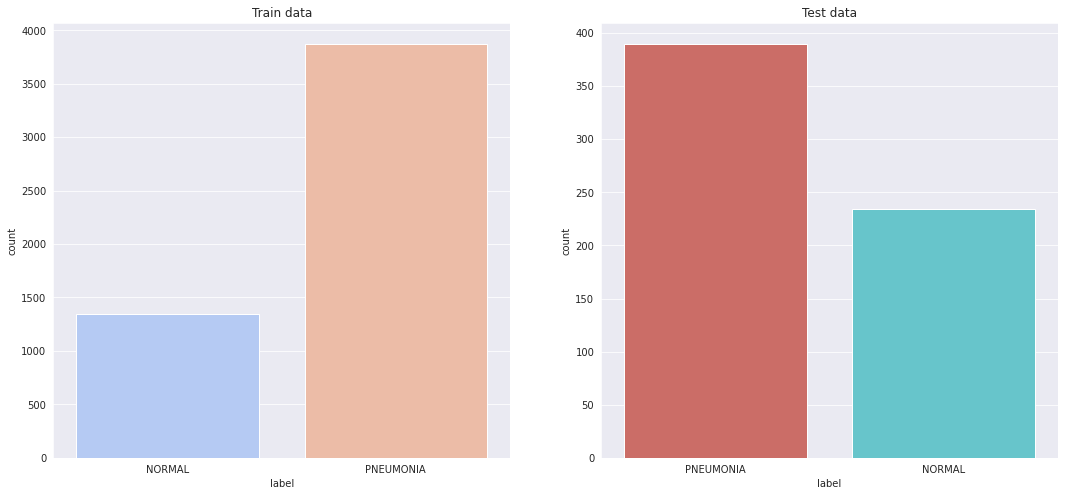

In [15]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

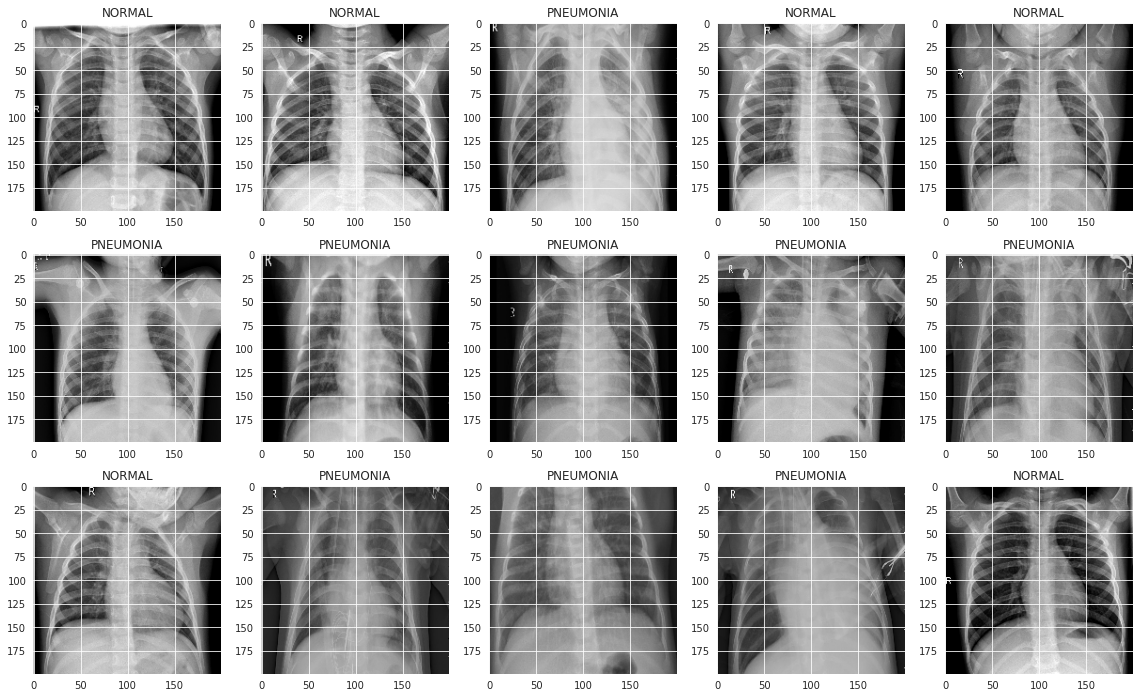

In [16]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

# Data preprocessing

In [17]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

#Function for dividing data into arrays X and y
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

# Split data
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

#  Grayscale conversion, normalization and table reshaping function for MLP
def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

#Function to drawing learning curve history learning neural network
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()


In [18]:
X_train = preprocesing_to_mlp(X_train)
X_test = preprocesing_to_mlp(X_test)

tcmalloc: large alloc 5007360000 bytes == 0x5644796c0000 @  0x7f5c2733e1e7 0x7f5c1e0f446e 0x7f5c1e144c7b 0x7f5c1e144d18 0x7f5c1e200d79 0x7f5c1e203e4c 0x7f5c1e322e7f 0x7f5c1e328fb5 0x7f5c1e32ae3d 0x7f5c1e32c516 0x564418a608a9 0x564418ad4b0a 0x564418acec35 0x564418a6173a 0x564418acfb0e 0x564418acec35 0x564418a6173a 0x564418ad3f40 0x564418a6165a 0x564418acfb0e 0x564418a6165a 0x564418ad3f40 0x564418a6165a 0x564418acfb0e 0x564418acec35 0x564418ace933 0x564418accda0 0x564418a5fea9 0x564418a5fda0 0x564418ad3bb3 0x564418b53bb5
tcmalloc: large alloc 1669120000 bytes == 0x5645a3e24000 @  0x7f5c2733e1e7 0x7f5c1e0f446e 0x7f5c1e144c7b 0x7f5c1e144d18 0x7f5c1e200d79 0x7f5c1e203add 0x7f5c1e32b9ba 0x7f5c1e32c516 0x564418a61280 0x564418a60e59 0x564418a43503 0x564418a448d0 0x564418ad733a 0x564418a6165a 0x564418ad3f40 0x564418a6165a 0x564418acfb0e 0x564418acec35 0x564418ace933 0x564418accda0 0x564418a5fea9 0x564418a5fda0 0x564418ad3bb3 0x564418b53bb5 0x564418ad0e23 0x564418b53bb5 0x564418ad0e23 0x564418b5

In [19]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

# MLP ([Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))

#### Structure

Firstly, let's think how the network should look like. It will have three layers:

1. Input Layer
1. Hidden Layer
1. Output Layer

Input layer has 200 * 200 pixels reshape to vector

Hidden layer has a lot of neurons

Output layer has 2 neurons: pneumonia / normal

![](https://austingwalters.com/wp-content/uploads/2018/12/mlp.png)

### Callbacks
* EarlyStopping (Stop training when a monitored metric has stopped improving)

* ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)

* ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

In [20]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('/content/working/model.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

#### First model

In [21]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [22]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,963,074
Trainable params: 40,963,074
Non-trainable params: 0
_________________________________________________________________


2021-08-19 12:44:32.714048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 12:44:33.071264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 12:44:33.072003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 12:44:33.076880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 12:44:33.077591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [23]:
#Fitting the model
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 40, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

2021-08-19 12:44:36.347400: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 834560000 exceeds 10% of free system memory.
2021-08-19 12:44:36.627656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2021-08-19 12:44:39.042679: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 99840000 exceeds 10% of free system memory.


82/82 - 3s - loss: 0.3963 - accuracy: 0.8196 - val_loss: 0.3656 - val_accuracy: 0.8478


2021-08-19 12:44:39.318535: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 163840000 exceeds 10% of free system memory.
2021-08-19 12:44:39.699311: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 163840000 exceeds 10% of free system memory.
2021-08-19 12:44:39.870882: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 163840000 exceeds 10% of free system memory.


Epoch 2/40
82/82 - 1s - loss: 0.1948 - accuracy: 0.9277 - val_loss: 0.3725 - val_accuracy: 0.8173
Epoch 3/40
82/82 - 1s - loss: 0.1488 - accuracy: 0.9431 - val_loss: 0.5509 - val_accuracy: 0.7708
Epoch 4/40
82/82 - 1s - loss: 0.1310 - accuracy: 0.9502 - val_loss: 0.6939 - val_accuracy: 0.7532
Epoch 5/40
82/82 - 1s - loss: 0.1265 - accuracy: 0.9503 - val_loss: 0.5705 - val_accuracy: 0.7837
Epoch 6/40
82/82 - 1s - loss: 0.1358 - accuracy: 0.9494 - val_loss: 0.4765 - val_accuracy: 0.8029
Epoch 7/40
82/82 - 1s - loss: 0.1176 - accuracy: 0.9569 - val_loss: 0.5708 - val_accuracy: 0.7949
Epoch 8/40
82/82 - 1s - loss: 0.1388 - accuracy: 0.9450 - val_loss: 0.7014 - val_accuracy: 0.7708
Epoch 9/40
82/82 - 1s - loss: 0.1059 - accuracy: 0.9592 - val_loss: 0.6991 - val_accuracy: 0.7692
Epoch 10/40
82/82 - 1s - loss: 0.1024 - accuracy: 0.9632 - val_loss: 0.7640 - val_accuracy: 0.7596
Epoch 11/40
82/82 - 1s - loss: 0.1000 - accuracy: 0.9601 - val_loss: 1.0254 - val_accuracy: 0.7260
Epoch 12/40
82/82 

In [24]:
# Loading the best model in terms of the loss metric
model = load_model('/content/working/model.best1.hdf5')

#Evaluation
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 93.14927458763123%
Test accuracy: 74.83974099159241%
MLP Error: 25.16%


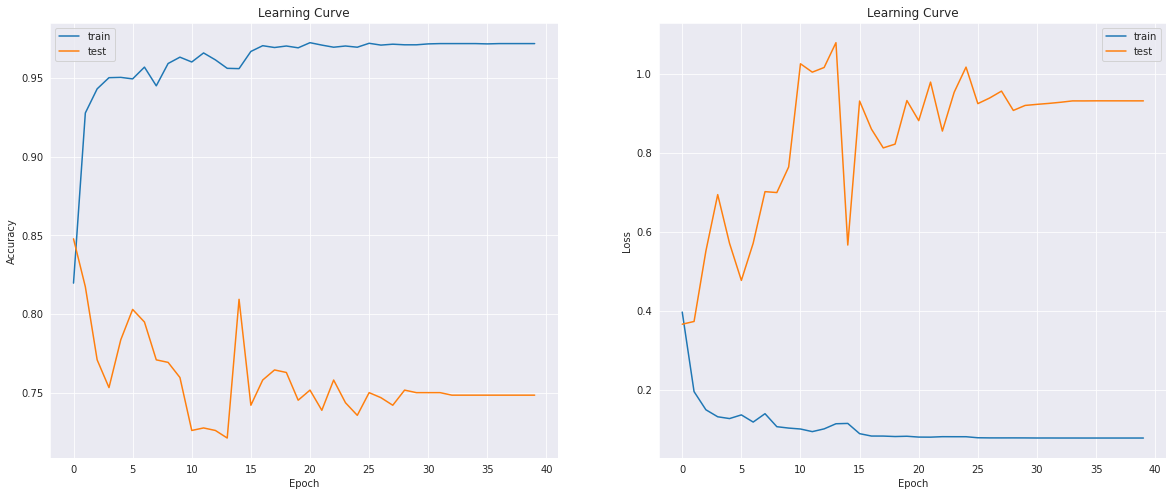

In [25]:
draw_learning_curve(learning_history)

# CNN ([Convolutional_neural_network](https://en.wikipedia.org/wiki/Convolutional_neural_network))

![](https://www.mdpi.com/diagnostics/diagnostics-10-00417/article_deploy/html/images/diagnostics-10-00417-g001.png)

Simple sequential model is used, starting with 5 double convolutional networks of kernel size **(3, 3)** and max pooling with pool size **(2, 2)**. 

Additionally has batch normalization and dropout

# Data preparing for CNN

In [26]:
#We need to rehaspe data again
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [27]:
#Grayscale conversion, normalization and table reshaping function for CNN
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [28]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

tcmalloc: large alloc 5007360000 bytes == 0x564607df0000 @  0x7f5c2733e1e7 0x7f5c1e0f446e 0x7f5c1e144c7b 0x7f5c1e144d18 0x7f5c1e200d79 0x7f5c1e203e4c 0x7f5c1e322e7f 0x7f5c1e328fb5 0x7f5c1e32ae3d 0x7f5c1e32c516 0x564418a608a9 0x564418ad4b0a 0x564418acec35 0x564418a6173a 0x564418acfb0e 0x564418acec35 0x564418a6173a 0x564418ad3f40 0x564418a6165a 0x564418acfb0e 0x564418a6165a 0x564418ad3f40 0x564418a6165a 0x564418acfb0e 0x564418acec35 0x564418ace933 0x564418accda0 0x564418a5fea9 0x564418a5fda0 0x564418ad3bb3 0x564418b53bb5
tcmalloc: large alloc 1669120000 bytes == 0x56450237a000 @  0x7f5c2733e1e7 0x7f5c1e0f446e 0x7f5c1e144c7b 0x7f5c1e144d18 0x7f5c1e200d79 0x7f5c1e203add 0x7f5c1e32b9ba 0x7f5c1e32c516 0x564418a61280 0x564418a60e59 0x564418a43503 0x564418a448d0 0x564418ad733a 0x564418a6165a 0x564418ad3f40 0x564418a6165a 0x564418acfb0e 0x564418acec35 0x564418ace933 0x564418accda0 0x564418a5fea9 0x564418a5fda0 0x564418ad3bb3 0x564418b53bb5 0x564418ad0e23 0x564418b53bb5 0x564418ad0e23 0x564418b5

In [29]:
num_classes = y_train.shape[1]

In [30]:
input_shape = (img_size, img_size, 1)

In [31]:
callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('/content/model.best2.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [32]:
num_pixels 

40000

#### First model CNN

In [33]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [34]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)     

#### Fitting the model

In [35]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks2,
          validation_data = (X_test, y_test))

Epoch 1/100


2021-08-19 12:48:12.185959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8004


82/82 [==============================] - 23s 92ms/step - loss: 1.1545 - accuracy: 0.7364 - val_loss: 0.9921 - val_accuracy: 0.6250
Epoch 2/100
82/82 [==============================] - 6s 77ms/step - loss: 0.3372 - accuracy: 0.8788 - val_loss: 1.9313 - val_accuracy: 0.6250
Epoch 3/100
82/82 [==============================] - 6s 77ms/step - loss: 0.2444 - accuracy: 0.9114 - val_loss: 0.6632 - val_accuracy: 0.6250
Epoch 4/100
82/82 [==============================] - 6s 77ms/step - loss: 0.1742 - accuracy: 0.9319 - val_loss: 1.2756 - val_accuracy: 0.6250
Epoch 5/100
82/82 [==============================] - 6s 77ms/step - loss: 0.1739 - accuracy: 0.9373 - val_loss: 1.0239 - val_accuracy: 0.6250
Epoch 6/100
82/82 [==============================] - 6s 76ms/step - loss: 0.1410 - accuracy: 0.9569 - val_loss: 1.4476 - val_accuracy: 0.6250
Epoch 7/100
82/82 [==============================] - 6s 76ms/step - loss: 0.1161 - accuracy: 0.9586 - val_loss: 4.8464 - val_accuracy: 0.6250
Epoch 8/100
82/82

In [36]:
model = load_model('/content/model.best2.hdf5')

In [37]:
# Evaluation
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 698.0441570281982%
Test accuracy: 70.35256624221802%
MLP Error: 29.65%


# Data Augmentation

I will try to improve the result by expanding the data.

#### Data augmentation:
* Randomly shift images horizontally by 10% of the width

* Randomly shift images vertically by 10% of the height

* Randomly rotate images by 10 degrees

* Randomly Zoom by 10% some images

In [38]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [39]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('/content/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

#### Second model CNN

It is very similar to first model, I'm changing only weight in dropout and add layer

In [40]:
def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
       
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [41]:
model = get_modelcnn_v2()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)     

#### Fitting the model

In [42]:
learning_history = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks3,
                        )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
163/163 [==============================] - 19s 107ms/step - loss: 0.5303 - accuracy: 0.7650 - val_loss: 3.6755 - val_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 17s 104ms/step - loss: 0.2894 - accuracy: 0.8898 - val_loss: 1.9720 - val_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 17s 104ms/step - loss: 0.2247 - accuracy: 0.9132 - val_loss: 2.4111 - val_accuracy: 0.6250
Epoch 4/100
163/163 [==============================] - 17s 104ms/step - loss: 0.1945 - accuracy: 0.9279 - val_loss: 1.4194 - val_accuracy: 0.6250
Epoch 5/100
163/163 [==============================] - 17s 105ms/step - loss: 0.1726 - accuracy: 0.9400 - val_loss: 3.4948 - val_accuracy: 0.6250
Epoch 6/100
163/163 [==============================] - 17s 104ms/step - loss: 0.1514 - accuracy: 0.9419 - val_loss: 3.9358 - val_accuracy: 0.6250
Epoch 7/100
163/163 [==============================] - 17s 104ms/step - loss: 0.1497 - accuracy: 0.9427 - val_loss: 3.1588 -

In [43]:
model = load_model('/content/model.best3.hdf5')

In [44]:
# Evaluate
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 20.985043048858643%
Test accuracy: 93.10897588729858%
MLP Error: 6.89%


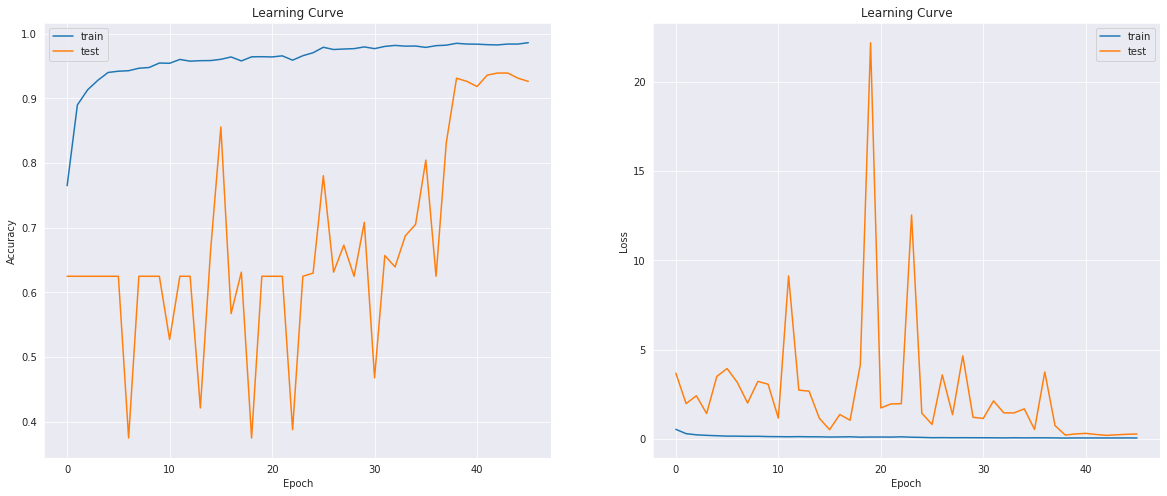

In [45]:
draw_learning_curve(learning_history)

In [46]:
# Let's see where the model was invalid
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [47]:
y_pre_test = np.argmax(y_test, axis = 1)

In [48]:
def show_condition(num):
    if num == 0:
        return 'NORMAL'
    return 'PNEUMONIA'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


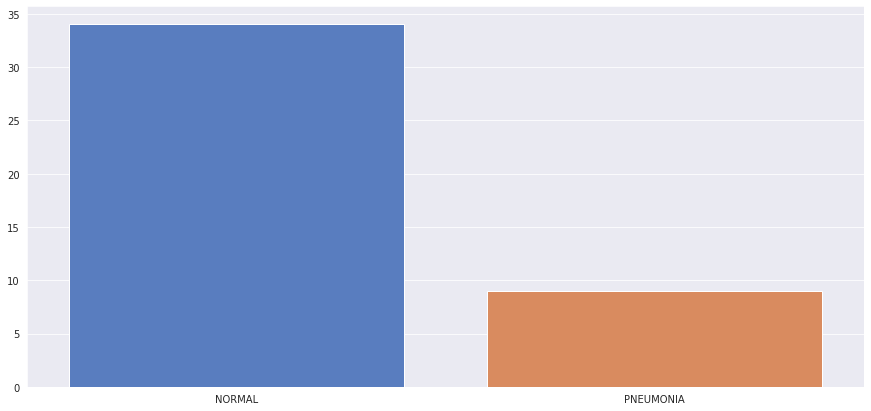

In [49]:
# Let's see the graph with the error amount for each label.
cnt_error = []
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if a == b: continue
    cnt_error.append(a)# test

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
sns.barplot([show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
plt.show()

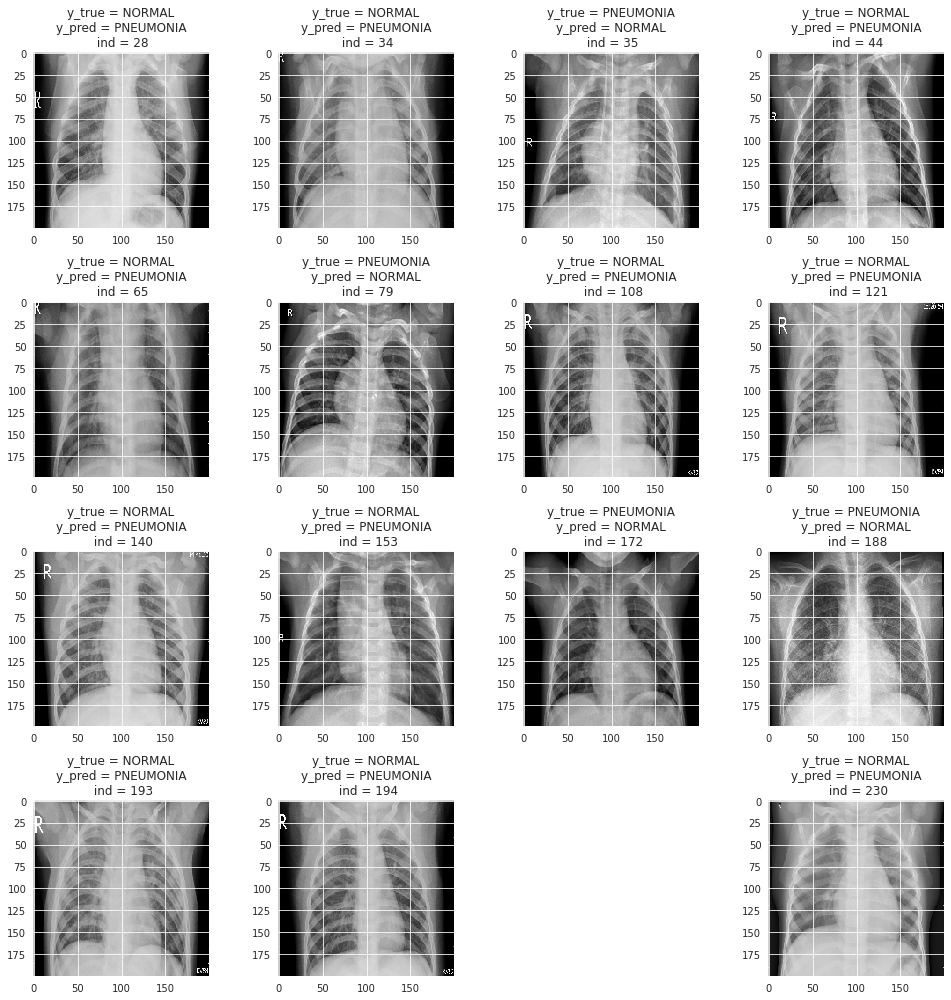

In [50]:
# Let's show images
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1

# Summary
The model is wrong when the patient has pneumonia and is diagnosed as healthy.

This is not good, but it occurs in less than 10% of the patients studied. 

It is quite possible that the doctor would not be sure of these cases either. 

By collecting more data from different people in different hospitals, from different parts of the world, we can generalize the data and increase the accuracy of diagnosis. 

In addition, this model can serve as a screening test for patients because, as shown in the graph, when the model recognizes a person with pneumonia is almost certain.

### Achievements in the notebook

In [51]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       234
           1       0.92      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624

